# Du Machine Learning pour de vrai ?

Jusqu'ici on a vu plusieurs techniques de machine learning, en particulier :
* des arbres de décision, à partir desquels on peut construire des forêts aléatoires, qui sont une technique d'apprentissage supervisé, permettant de faire de la classification ;
* du clustering, qui permet de regrouper ensemble les points qui se ressemblent le plus ;
* de la projection en espace de plus faible dimension, permettant de visualiser nos points ;
* de la propagation de labels, qui permettent de donner des labels à l'ensemble de nos données à partir d'un petit ensemble de points correctement labellisés.

Mais on n'a utilisé ces techniques que sur des datasets synthétiques, très simples, et parfois peut-être un peu trop simples.
On va donc voir comment on peut essayer d'utiliser ces techniques pour analyser un jeu de données, on va donc essayer de :
* représenter nos données, malgré leur dimension trop importante pour être représentées directement ;
* regrouper des points ensemble, et voir si on arrive à en dire quelque chose ;
* trouver les paramètres (profondeur des arbres, nombre d'arbres, etc.) qui permettent de prédire des choses à partir de nos données.

Bien sûr, ces techniques ne sont pas les seules qui existent, ni nécessairement celles qui sont les plus efficaces.
En revanche, elles sont toutes basées sur des méthodes de graphes, en construisant une représentation sous forme de graphe de nos données.
(Et en fait, elles donnent très souvent de très bons résultats ! :) )

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns ; sns.set()

## Jeu de données

Cette fois, on va essayer d'apprendre des choses sur des données réelles.
On dispose d'un jeu de données dont chaque ligne représente une enregistrement musical, dont ont été extraite une série de mesures, ainsi que le genre musical.

Notre objectif final est d'essayer de prédire ce genre musical à partir des autres variables.

Contrairement aux jeux de données synthétiques qu'on a utilisés jusqu'ici, on va d'abord essayer de comprendre à quoi ressemblent nos données.

### Chargement et premières observations

Commençons par charger nos données à l'aide de la librairie `pandas`.

In [3]:
data = pd.read_csv("dataset.csv")

On peut ensuite regarder la répartition des valeurs de chacune des variables.

In [4]:
data.describe(include="all")

file_name  zero_crossing  spectral_centroid  \
count                             1742    1742.000000        1742.000000   
unique                            1742            NaN                NaN   
top     01. Aaj Sraboner Amontrone.mp3            NaN                NaN   
freq                                 1            NaN                NaN   
mean                               NaN  215007.465557        2015.700468   
std                                NaN   89920.930842         721.696480   
min                                NaN       0.000000           0.000000   
25%                                NaN  152359.000000        1533.507050   
50%                                NaN  196971.500000        2033.964745   
75%                                NaN  257056.250000        2495.077302   
max                                NaN  757737.000000        5323.086970   

        spectral_rolloff  spectral_bandwidth  chroma_frequency         rmse  \
count        1742.000000         1742.000000       1742.000000  1742.000000   
unique               NaN                 NaN               NaN          NaN   
top                  NaN                 NaN               NaN          NaN   
freq                 NaN                 NaN               NaN          NaN   
mean         4100.426211         2043.560009          0.305385     0.171471   
std          1597.279461          666.244323          0.072464     0.075168   
min             0.000000            0.000000          0.000000     0.000000   
25%          2962.049702         1699.097722          0.249591     0.118410   
50%          4226.889780         2223.573271          0.294676     0.160642   
75%          5258.493696         2532.093962          0.351839     0.214249   
max          8810.877261         3252.209261          0.616620     0.628826   

               delta  melspectogram        tempo  ...       mfcc11  \
count   1.742000e+03    1742.000000  1742.000000  ...  1742.000000   
unique           NaN            NaN          NaN  ...          NaN   
top              NaN            NaN          NaN  ...          NaN   
freq             NaN            NaN          NaN  ...          NaN   
mean   -1.743660e-09       8.522913   123.112315  ...     0.117813   
std     1.393930e-07       7.374733    21.849677  ...     5.985646   
min    -1.676001e-06       0.000000    73.828125  ...   -25.692529   
25%    -6.728298e-08       3.576854   107.666016  ...    -3.046898   
50%     1.617425e-10       6.477533   123.046875  ...     0.643217   
75%     6.924068e-08      11.528968   135.999178  ...     3.916396   
max     6.417627e-07      83.923833   184.570312  ...    20.077568   

             mfcc12       mfcc13       mfcc14       mfcc15       mfcc16  \
count   1742.000000  1742.000000  1742.000000  1742.000000  1742.000000   
unique          NaN          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN          NaN   
mean      -5.085212    -1.104625    -4.488481    -0.222948    -4.636100   
std        5.253280     5.643891     4.682304     4.659930     4.515759   
min      -24.642862   -26.359570   -23.886369   -20.935224   -21.520218   
25%       -8.325668    -3.995158    -7.407150    -2.824771    -7.600435   
50%       -4.750612    -0.513353    -4.537535     0.162360    -4.908912   
75%       -1.735095     2.440787    -1.597814     2.756847    -2.071220   
max       14.958208    16.891013    24.020983    20.451894    19.347293   

             mfcc17       mfcc18       mfcc19   label  
count   1742.000000  1742.000000  1742.000000    1742  
unique          NaN          NaN          NaN       6  
top             NaN          NaN          NaN  nazrul  
freq            NaN          NaN          NaN     312  
mean       0.331630    -4.160293    -0.704487     NaN  
std        4.447436     4.531011     4.433841     NaN  
min      -17.205040   -24.743798 

On a donc un jeu de données avec 1742 lignes et 31 colonnes, c'est à dire 1742 oservations de 31 variables différentes.

Les variables ont des échelles assez différentes (il suffit de regarder la ligne `mean`), on va voir si ça nous pose des problèmes plus tard.

La variable `file_name` contient 1742 valeurs différentes.
En fait, c'est simplement le nom des fichiers correspondant à chacune des musiques... 
pas très intéressant, on enlève !

In [5]:
data = data.drop(["file_name"], axis=1)

**Question 1.** Affichez le tableau récapitulatif comme ci-dessus et vérifiez que la variable `file_name` a bien été enlevée.

### Corrélations entre les variables

Avant d'essayer de faire quelque chose avec nos variables, on peut regarder si elles sont corrélées entre elles.
La corrélation entre deux variables est une mesure statistique définie ainsi :
$$ Corr(X, Y) = \frac{E((X-E(X))(Y-E(Y))}{\sigma_X \sigma_Y}, $$
où $\sigma_X$ et $\sigma_Y$ sont les écart-types de $X$ et $Y$.

C'est en vait la covariance de $X$ et $Y$, normalisées par leurs écart-types.

Ce qu'il faut retenir, c'est surtout que c'est une valeur entre $-1$ et $1$, et que plus elle est proche de $-1$ ou de $1$, plus les variables sont corrélées.
A priori, quand la corrélation entre deux variables est importante, avoir les deux variables n'apporte pas beaucoup plus d'information que d'avoir une seule des deux.

<AxesSubplot:>

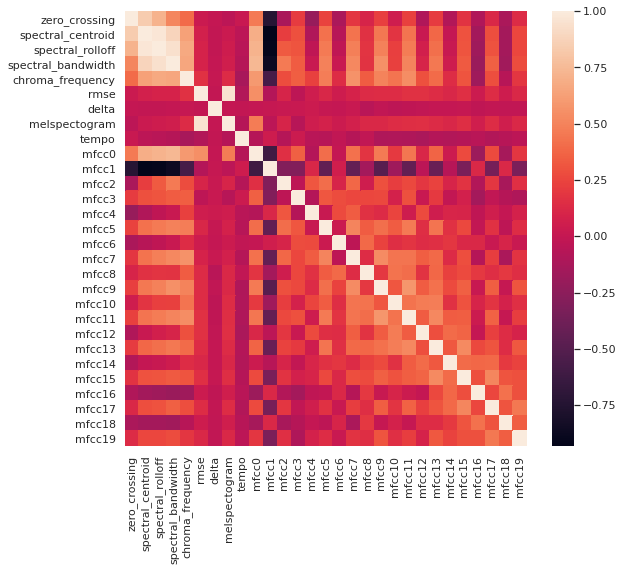

In [6]:
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(data.corr(method="pearson"), ax=ax)

On remarque que les variables `spectral_centroid`, `spectral_rolloff`, `spectral_bandwidth` et `mfcc1` sont très corrélées.
De même, `rmse` et `melspetrogram` sont également très corrélées.

On va donc enlever les variables qui font doublon, et générer un dataset, avec les features dans une variable $X$, et les labels dans un variable $y$.

In [7]:
df_removed = data.drop(["spectral_rolloff", "spectral_bandwidth", "mfcc1", "melspectogram"], axis=1)

X = df_removed.loc[:, df_removed.columns != "label"]
y = df_removed["label"]

Enlever les variables trop corrélées n'est pas inspensable, et aura a priori un impact limité sur la qualité de nos prédictions en utilisant des arbres de décision.
Souvenez vous : les arbres de décision apprennent des questions sur les valeurs des variables.
Ces questions sont de la forme $X_i < a$, où $a$ est un seuil appris lors de l'entraînement.

Dans ce cas, on peut raisonnablement s'attendre à ce qu'avoir une variable en double n'ait qu'un effet limité sur le résultat final, car répondre à la question sur une variable ou sur une autre devrait donner des résultats proches.
Cela pourrait en revanche ralentir l'entraînement car l'ensemble des questions possibles serait inutilement grand.

Pour l'affichage par la suite, on va garder en mémoire une variable `labels` avec des numéros qui permettront d'afficher les couleurs sur nos dessins :

In [8]:
music_styles = np.unique(y)
music_style_encoding = {m: i for i, m in enumerate(music_styles)}
labels = np.array(list(map(music_style_encoding.get, list(y))))

## Représentation des données ?

On y voit un peu plus clair, et on a pu enlever les variables qui nous paraissent les moins utiles.
On va essayer de représenter nos données comme on a déjà essayé de le faire dans les TP précédents.

Évidemment, on ne va pas tout recoder, utilisons `SpectralEmbedding` :

In [9]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2)
X2 = embedding.fit_transform(X)

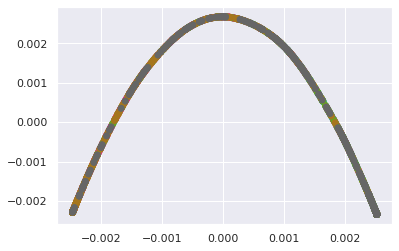

In [10]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap="Dark2")

**Question 2.** Que dire de cette représentation ? Est-elle satisfaisante ?

*Réponse :*

En fait c'est dû aux différences d'échelles des données... ça fait n'importe quoi parce que des variables sont vraiment beaucoup plus grandes que d'autres.

On va normaliser les données :

In [11]:
from sklearn.preprocessing import scale

Xscaled = scale(X)

On peut afficher à nouveau le descriptif de nos variables :

In [12]:
df_scaled = pd.DataFrame(Xscaled)
df_scaled.columns = X.columns
df_scaled.describe()

zero_crossing  spectral_centroid  chroma_frequency          rmse  \
count   1.742000e+03       1.742000e+03      1.742000e+03  1.742000e+03   
mean    2.826862e-16      -1.948626e-17     -1.574197e-16  8.030316e-17   
std     1.000287e+00       1.000287e+00      1.000287e+00  1.000287e+00   
min    -2.391759e+00      -2.793805e+00     -4.215485e+00 -2.281819e+00   
25%    -6.969062e-01      -6.683307e-01     -7.701652e-01 -7.060944e-01   
50%    -2.006334e-01       2.531469e-02     -1.478245e-01 -1.441053e-01   
75%     4.677538e-01       6.644268e-01      6.412391e-01  5.692530e-01   
max     6.037364e+00       4.584110e+00      4.296243e+00  6.086163e+00   

              delta         tempo         mfcc0         mfcc2         mfcc3  \
count  1.742000e+03  1.742000e+03  1.742000e+03  1.742000e+03  1.742000e+03   
mean  -1.657049e-18 -7.277314e-16  2.516803e-16  1.325958e-16  7.459908e-17   
std    1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00   
min   -1.201451e+01 -2.256250e+00 -1.159683e+01 -4.554401e+00 -4.679039e+00   
25%   -4.703116e-01 -7.071379e-01 -6.171237e-01 -6.065826e-01 -3.884310e-01   
50%    1.367321e-02 -2.995879e-03  1.308499e-01  1.638622e-01  1.296066e-02   
75%    5.093852e-01  5.899658e-01  7.070439e-01  7.036774e-01  5.201561e-01   
max    4.617816e+00  2.813572e+00  2.832922e+00  3.292609e+00  4.427734e+00   

              mfcc4  ...        mfcc10        mfcc11        mfcc12  \
count  1.742000e+03  ...  1.742000e+03  1.742000e+03  1.742000e+03   
mean   1.218569e-16  ... -4.336410e-17  9.005426e-17  2.137594e-16   
std    1.000287e+00  ...  1.000287e+00  1.000287e+00  1.000287e+00   
min   -4.716782e+00  ... -4.554122e+00 -4.313277e+00 -3.724010e+00   
25%   -5.633696e-01  ... -5.776729e-01 -5.288686e-01 -6.170215e-01   
50%    9.521434e-02  ...  6.462766e-02  8.780251e-02  6.371191e-02   
75%    6.215948e-01  ...  6.500392e-01  6.347975e-01  6.379022e-01   
max    3.548240e+00  ...  3.347441e+00  3.335561e+00  3.816506e+00   

             mfcc13        mfcc14        mfcc15        mfcc16        mfcc17  \
count  1.742000e+03  1.742000e+03  1.742000e+03  1.742000e+03  1.742000e+03   
mean  -2.813160e-16  2.272070e-17  1.666609e-16  9.630006e-17 -5.697700e-17   
std    1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00  1.000287e+00   
min   -4.476025e+00 -4.143998e+00 -4.446038e+00 -3.740006e+00 -3.944229e+00   
25%   -5.122998e-01 -6.235195e-01 -5.584997e-01 -6.566306e-01 -5.503997e-01   
50%    1.047931e-01 -1.047961e-02  8.270927e-02 -6.043073e-02  3.676296e-02   
75%    6.283661e-01  6.175373e-01  6.396343e-01  5.681474e-01  6.281729e-01   
max    3.189432e+00  6.090517e+00  4.438002e+00  5.312568e+00  4.404748e+00   

             mfcc18        mfcc19  
count  1.742000e+03  1.742000e+03  
mean  -1.165511e-16 -9.572646e-17  
std    1.000287e+00  1.000287e+00  
min   -4.544111e+00 -3.600761e+00  
25%   -6.079892e-01 -5.757751e-01  
50%   -5.924763e-02  3.804522e-02  
75%    5.143577e-01  6.135962e-01  
max    5.625806e+00  4.889305e+00  

[8 rows x 25 columns]

**Question 3.** Que dire des valeurs de `mean` et `std` maintenant ?

*Réponse :*

**Question 4.** Calculer à nouveau le SpectralEmbedding de ce jeu de données normalisé. Qu'en pensez-vous ?

Bon il n'y a pas forcément de répartition évidente entre les six groupes, mais même si c'est pas évident on dirait quand même qu'il y a une certaine forme de structure, puis on perd pas mal d'information quand on projette ainsi...

Par la suite, on utilisera la version normalisée de `X`, remplaçons donc la valeur de `X` par son équivalent normalisé :

In [14]:
X = scale(X)

## Clustering ?

Imaginons un instant que l'on a que les valeurs de $X$, mais qu'on ignore les labels $y$.
Essayons de faire du clustering :

In [15]:
from sklearn.cluster import KMeans

In [16]:
kmeans = KMeans(n_clusters=6)
pred_kmeans = kmeans.fit_predict(Xscaled)

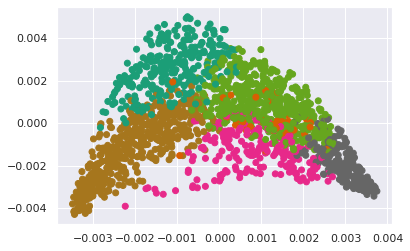

In [17]:
plt.scatter(X2scaled[:, 0], X2scaled[:, 1], c=pred_kmeans, cmap="Dark2")

Aux vues de ce qu'on avait dans la partie précédente, ça n'a pas l'air si convainquant... si vous avez encore du temps à la fin, ou envie d'en apprendre plus, vous pouvez faire le DM sur l'évaluation du clustering, pour voir une façon d'évaluer une méthode de clustering.

En fait une façon d'évaluer une méthode de clustering est de calculer le score de silhouette.
C'est un score défini à partir de $X$ et des clusters prédits, qui vaut entre $-1$ et $1$, plus il est proche de $-1$ ou $1$, et plus les clusters sont séparés les uns des autres.
En revanche, plus il est proche de $0$, moins le clustering est bon, et plus les clusters se superposent les uns aux autres.

Par exemple, pour le clustering obtenu ci-dessus, on a :

In [18]:
from sklearn.metrics import silhouette_score

silhouette_score(Xscaled, pred_kmeans)

0.09304312180836477

Ce qui est très proche de zéro. On a donc un clustering de bien mauvaise qualité...

Vous pouvez essayer avec un nombre de clusters différent de $6$ et voir que vous obtenez toujours un résultat similaire.

Si vous vous ennuyez, vous pouvez faire le DM (bonus et facultatif) sur l'évaluation du clustering, où le but est de calculer un score similaire à la silhouette pour le clustering, et la silhouette si vous avez vraiment rien de mieux à faire.

## Prédiction ?

### Une référence ?

On va commencer par découper le dataset en deux parties, en gardant un tiers de nos données pour vérifier que l'on est pas en train de faire (trop) d'overfitting.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Avant d'aller plus loin, on a besoin d'une référence, d'une notion qui nous permette de savoir si le modèle que l'on a appris a un sens ou pas.

Pour cela, on va commencer par voir ce qu'il se passe si l'on renvoie un label au hasard, ou si on renvoie tout le temps le label le plus fréquent.
L'objet `DummyClassifier` fonctionne comme `DecisionTree`, on l'entraîne avec la méthode `fit` puis on prédit de nouvelles valeurs avec la méthode `predict`.

On obtient les scores suivants :

In [20]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print("Prédiction du plus fréquent :", dummy_clf.score(X_test, y_test))


dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
print("Prédiction au pif :", dummy_clf.score(X_test, y_test))

Prédiction du plus fréquent : 0.1791304347826087
Prédiction au pif : 0.16521739130434782


Donc si on fait moins bien que ça, c'est qu'on a appris un classifieur vraiment inutile.
Si on est au dessus, on a au moins appris un peu.

### Arbres de décision ?

Dans cette partie, on va entraîner des arbres de décision.
Puis on va faire des forêts aléatoires, et on va essayer de trouver les paramètres qui vont bien.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Voilà une fonction de score qui renvoie la proportion de bonnes prédictions sur un ensemble :

In [22]:
def score(clf, X, y):
    pred = clf.predict(X)
    return np.mean(pred == y)

**Question 5.** Entraînez un arbre de décision `DecisionTreeClassifier` sur les données d'entraînement et affichez son score de prédiction sur les datasets d'entraînement et de test. Que constatez-vous ? Est-ce normal ?

**Question 6.** Faites varier la profondeur maximale de l'arbre en changeant le paramètre `max_depth` et calculez le score en entrainement et en test. Que constatez-vous ?

**Question 7.** Entraînez une forête aléatoire `RandomForestClassifier` sur les données d'entraînement et affichez son score de prédiction sur les datasets d'entraînement et de test.

**Question 8.** Faites varier les paramètres `n_estimators` et `max_depth` de `RandomForestClassifier`, et renvoyez les paramètres qui marchent le mieux en test.

*Remarque :* vous utiliserez deux boucles imbriquées les unes dans les autres pour faire varier les deux paramètres en même temps.

### Cross Validation

En fait, en procédant comme on l'a fait à la question précédente, on apprend un classifieur biaisé.
En effet, on choisit les paramètres pour lesquels la performance en test est la meilleure, donc, à force, si on cherche parmi beaucoup de paramètres, un risque important est celui de faire de l'overfitting sur les données de test.

Pour éviter cela, on va mettre de côté l'ensemble de test pour l'instant, et utiliser l'ensemble d'entraînement à la fois comme ensemble d'entrainement **et de test**.

On divise donc à nouveau notre ensemble d'entraînement en deux parties : 
* un sous-ensemble d'entraînement (plus petit donc) ;
* un sous-ensemble **de validation**.

Ainsi, on va pouvoir entraîner notre modèle sur ce sous-ensemble d'entraînement, puis valider sa performance sur le sous-ensemble de validation.
On va donc utiliser le sous-ensemble de validation comme à la question précédente.

Et en fait, on peut même faire un petit peu mieux : on peut choisir plusieurs découpages de cet ensemble d'entraînement différents (par exemple en prenant 2/3 des points au hasard pour l'entraînement et 1/3 pour la validation, puis en recommençant ainsi plusieurs fois, on obtient plusieurs découpages différents de notre ensemble).
Cela permet d'entraîner notre modèle sur chacun de ces sous-ensembles, puis d'évaluer leur performance sur chacun des sous-ensembles de validation, donnant un estimateur plus stable de l'erreur, et donc un choix plus stable des hyperparamètres.

C'est ce qu'on appelle la **cross-validation**.

Enfin, une fois que l'on a entraîné nos modèles de cette façon là, on peut regarder le résultats sur les données de test, pour avoir une **estimation** de l'erreur en test.

La fonction `cross_validate` permet de faire ces opérations sans avoir à tout réimplémenter.
Par exemple, pour voir le résultat d'un classifieur sur $5$ découpages différents de notre ensemble, on peut procéder ainsi :

In [23]:
from sklearn.model_selection import cross_validate

clf = DecisionTreeClassifier()

cross_validate(clf, X_train, y_train, 
               return_train_score=True, cv=5)

{'fit_time': array([0.02041817, 0.01682687, 0.0170908 , 0.01545501, 0.01597548]),
 'score_time': array([0.00094748, 0.00055718, 0.00055718, 0.00047565, 0.00044656]),
 'test_score': array([0.64529915, 0.58119658, 0.4806867 , 0.57081545, 0.53648069]),
 'train_score': array([1.        , 0.99892819, 1.        , 0.99892934, 0.99892934])}

**Remarque importante :** la fonction `cross_validate` renvoie les scores en entraînement dans `train_score` et les scores **en validation** dans `test_score`, car pour lui, c'est un jeu de données de test.

**Question 9.** Comme à la question précédente, entraînez un arbre de décision avec différentes valeurs de `max_depth`, puis prenez celui qui obtient le meilleur score moyen en validation.

**Question 10.** Évaluez maintenant la performance sur les données de test, que vous n'avez normalement pas touchées jusqu'ici. Commentez la différence avec le score en validation.